## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!pwd

/home/ubuntu/work/SAM_demo0


In [2]:
!nvidia-smi

Sun Apr 16 12:30:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Segment Anything Model (SAM) and other dependencies

In [3]:
import sys

!pip install -r requirements.txt
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z4hru95w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z4hru95w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done


# download dataset from Google Drive

In [4]:
import gdown
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import supervision as sv

Dataset_name = "Egg"
Dataset_name = "Can"


if Dataset_name == "Egg":
    # # same as the above, but with the file ID
     id = "1V-Lr_FQaysX9tlu29MQAQkeBIveDhiC6"
     zip_output = "Egg_Dataset.zip"
else :
    # same as the above, but with the file ID
    id = "1-AQSLwoycnOMruAeTXA7zGt92mfvRyk0"
    zip_output = "Can_Dataset.zip"

    

# Download the file from `url` and save it locally 
if not os.path.isdir( zip_output.split(".")[0] ):
    gdown.download(id=id, output= zip_output, quiet=False)
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall('.')
    
    # delete zip file
    os.remove(zip_output)    

## Find Image Files

In [5]:

def find_jpg_files(folder_path):
    jpg_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith(".jpeg"):
                jpg_files.append(os.path.join(root, file))
    return jpg_files



jpg_files           = find_jpg_files(zip_output.split(".")[0])

print("files = ", len(jpg_files),'\n')

jpg_files[0:5]

files =  510 



['Can_Dataset/1/anormal/down/IMG_0686.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0727.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0696.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0690.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0756.jpeg']

### Download SAM weights

In [6]:
if not os.path.isdir("weights") :
    os.mkdir("weights")

if not os.path.isfile("./weights/sam_vit_h_4b8939.pth") :
   !wget -q -P ./weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  

## Load Model (Take a Minutes)

In [7]:
%%time
import torch
from  segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.empty_cache()

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


if 'sam' in globals() or 'variable_name' in locals():
    # sam is defined
    print("Sam is already define")
else:
    sam            = sam_model_registry["vit_h"](checkpoint="./weights/sam_vit_h_4b8939.pth").to(device=DEVICE)
    mask_generator = SamAutomaticMaskGenerator(sam)



print(f"Device = {DEVICE} with Memory = ",torch.cuda.memory_allocated() / 1024 ** 2, "MB")

Device = cuda:0 with Memory =  2509.58056640625 MB
CPU times: user 9.95 s, sys: 5.37 s, total: 15.3 s
Wall time: 33.4 s


# Radom single image to test model

Text(0.5, 1.0, 'IMG_0401.jpeg')

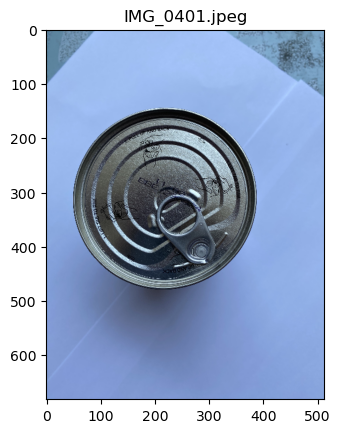

In [8]:
def GetImage(path, new_w = 512):
    
    image_bgr  = cv2.imread(IMAGE_PATH)
    # Get the current height and width of the image
    h, w = image_bgr.shape[:2]
    # Calculate the new height with the same aspect ratio
    new_w = min(w,new_w)
    ratio = new_w / w
    image_bgr = cv2.resize(image_bgr , (int(new_w), int(int(h * ratio))))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    return image_rgb 



IMAGE_PATH = random.sample(jpg_files, 1)[0] 
image_rgb = GetImage(IMAGE_PATH , new_w = 512)

   
plt.imshow(image_rgb)
plt.title(IMAGE_PATH.split('/')[-1])




# Run SAM

In [10]:
% time
# Clear CUDA memory
torch.cuda.empty_cache()
sam_result = mask_generator.generate(image_rgb)

print(len(sam_result))
print(sam_result[0].keys())

23
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Preview masks with SAM

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [9]:
%%time

def SAM_Image_Compare(sam_result, image_rgb):
   
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR) 
    mask_annotator = sv.MaskAnnotator()
    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        size=(12, 12),
        titles=['source image', 'segmented image']
    )

    
SAM_Image_Compare(sam_result, image_rgb)

NameError: name 'sam_result' is not defined

# Separate Mask

In [17]:
masks     = [ mask['segmentation'].astype(np.uint8) * 255 for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
bboxs     = [ mask['bbox'] for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
segments  =  [ cv2.bitwise_and(image_rgb, image_rgb, mask=img_binary) for img_binary in  masks]


print(len(masks), len(bboxs) , len(segments))

17 17 17


### Interaction with segmentation results

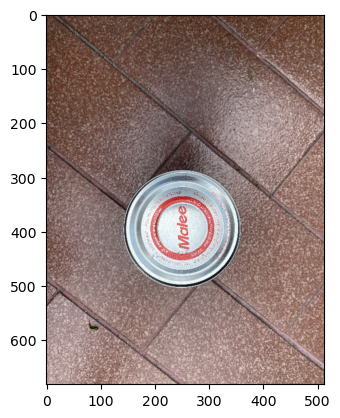

In [13]:
plt.imshow(image_rgb)

In [16]:
%%time  
sam_result = mask_generator.generate(image_rgb)

CPU times: user 2.49 s, sys: 451 ms, total: 2.94 s
Wall time: 2.93 s


In [18]:
# Convert the True/False image to a binary image
img_binary = (img_gray.astype(np.uint8) * 255)

NameError: name 'img_gray' is not defined

In [22]:
image = image_rgb.copy()

masks     = [ mask['segmentation'].astype(np.uint8) * 255 for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
bboxs     = [ mask['bbox'] for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]

segments  =  [ cv2.bitwise_and(image, image, mask=img_binary) for img_binary in  masks]






In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns
n_rows = 5  # Change this to the number of rows you want
n_cols = 3

# Create the figure and axes for the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axes so we can iterate over them using a single loop
axs = axs.flatten()

# Create each subplot and plot the data
for i in range(n_rows * n_cols):
    if i % 3 == 0:
        axs[i].plot(x, y1)
    elif i % 3 == 1:
        axs[i].plot(x, y2)
    else:
        axs[i].plot(x, y3)

# Set the title for each subplot
for i, ax in enumerate(axs):
    ax.set_title(f"Plot {i+1}")

# Set the overall title for the figure
fig.suptitle("My Plot")

# Show the plot
plt.show()

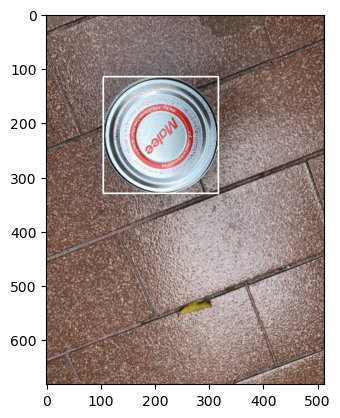

In [63]:
bbox = bboxs[9]

plt.imshow(cv2.rectangle(image_rgb.copy(), (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255,255,255), thickness=2))

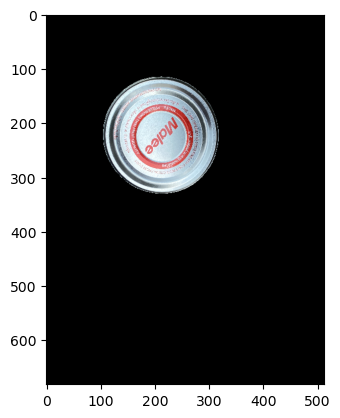

In [62]:
plt.imshow(segments[9])

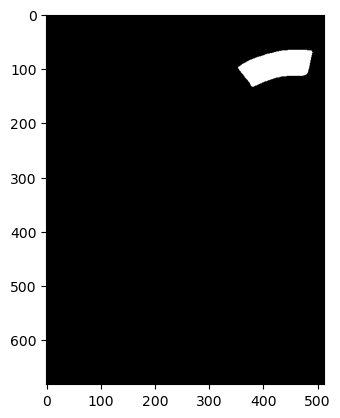

In [31]:
plt.imshow(masks[3],cmap='gray')   

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the images and masks are stored in numpy arrays
# with shape (10, height, width, channels)
images = np.random.rand(10, 256, 256, 3)
masks = np.random.randint(0, 2, (10, 256, 256, 1))

# Create a subplot of 20*2
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(8, 40))

# Loop through the images and masks and plot them
for i in range(10):
    # Plot the image in the first column of the subplot
    ax[i, 0].imshow(images[i])
    ax[i, 0].set_title("Image {}".format(i+1))
    ax[i, 0].axis("off")

    # Plot the mask in the second column of the subplot
    ax[i, 1].imshow(masks[i], cmap="gray")
    ax[i, 1].set_title("Mask {}".format(i+1))
    ax[i, 1].axis("off")

# Show the plot
plt.tight_layout()
plt.show()
